In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

#nlp
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer, WhitespaceTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
import re

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint

import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [9]:
#nltk.download('stopwords')

In [11]:
filename = '../../data/nlp_nltk_stemmed_preproc.csv'

In [12]:
df = pd.read_csv(filename).drop(columns='Unnamed: 0')

In [13]:
df.head()

,claps,text
0,398,"['python', 'builtin', 'database', '—', 'here’s..."
1,203,"['build', 'deploy', 'dashboard', 'python', 'go..."
2,360,"['magic', 'python', 'context', 'manager', 'get..."
3,88,"['generating', 'image', 'segmentation', 'mask'..."
4,301,"['top', '5', 'machine', 'learning', 'certifica..."


In [14]:
text_string = ','.join(list(df['text'].values))

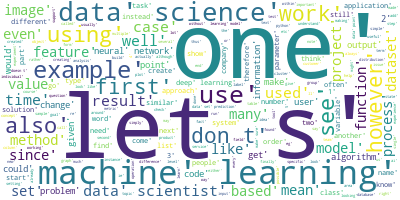

In [15]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate & Visualize a word cloud
wordcloud.generate(text_string);
# Visualize the word cloud
wordcloud.to_image()

In [16]:
stop_words = stopwords.words('english')

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [18]:
data = df['text'].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['python', 'builtin', 'database', 'use', 'utilize', 'builtin', 'database', 'data', 'python', 'builtin', 'database', 'use', 'problem', 'overview', 'creating', 'table', 'create', 'read', 'update', 'delete', 'test', 'time', 'go', 'database', 'great', 'secure', 'reliable', 'way', 'store', 'data']


In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 2), (12, 2), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 2), (23, 3), (24, 1), (25, 1), (26, 3), (27, 1), (28, 1), (29, 3)]


In [23]:
start_time = time.time()
# number of topics
num_topics = 20
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      random_state=100,
                                      passes=10)

# Save trained model
lda_model.save('LDA_models/LDA_TDS20_multicore')

lda_multicore_model = gensim.models.ldamodel.LdaModel.load('LDA_models/LDA_TDS20_multicore')

## Print time taken to train the model
print("--- %s seconds ---" % (time.time() - start_time))

# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

--- 45.274725914001465 seconds ---
[(0,
  '0.016*"data" + 0.009*"app" + 0.009*"use" + 0.008*"user" + 0.008*"table" + '
  '0.007*"streamlit" + 0.007*"using" + 0.006*"power" + 0.006*"see" + '
  '0.005*"one"'),
 (1,
  '0.020*"data" + 0.015*"model" + 0.014*"value" + 0.011*"regression" + '
  '0.010*"feature" + 0.010*"variable" + 0.009*"algorithm" + 0.008*"point" + '
  '0.007*"cluster" + 0.007*"dataset"'),
 (2,
  '0.019*"function" + 0.019*"data" + 0.013*"column" + 0.012*"value" + '
  '0.011*"python" + 0.011*"use" + 0.009*"list" + 0.008*"code" + 0.008*"using" '
  '+ 0.007*"let"'),
 (3,
  '0.021*"model" + 0.020*"network" + 0.015*"layer" + 0.014*"image" + '
  '0.014*"training" + 0.012*"neural" + 0.010*"learning" + 0.009*"function" + '
  '0.009*"input" + 0.009*"loss"'),
 (4,
  '0.023*"data" + 0.011*"file" + 0.010*"database" + 0.008*"code" + 0.008*"use" '
  '+ 0.007*"using" + 0.006*"need" + 0.006*"time" + 0.006*"one" + '
  '0.006*"table"'),
 (5,
  '0.014*"language" + 0.010*"data" + 0.008*"article

In [24]:
# Compute Perplexity Score
print('nPerplexity Score: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

nPerplexity Score:  -7.948482536753489
nCoherence Score:  0.368357079378931


In [28]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(lda_model, corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, 'figures/LDA_TDS20.html')

### Ten Topics

In [29]:
start_time = time.time()
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      random_state=100,
                                      passes=10)

# Save trained model
lda_model.save('LDA_models/LDA_TDS10_multicore')

lda_multicore_model = gensim.models.ldamodel.LdaModel.load('LDA_models/LDA_TDS10_multicore')

## Print time taken to train the model
print("--- %s seconds ---" % (time.time() - start_time))

# Print the Keywords in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

--- 42.280779123306274 seconds ---
[(0,
  '0.016*"data" + 0.008*"use" + 0.008*"using" + 0.007*"app" + 0.007*"user" + '
  '0.005*"create" + 0.005*"need" + 0.005*"see" + 0.005*"one" + 0.005*"map"'),
 (1,
  '0.026*"model" + 0.020*"data" + 0.013*"feature" + 0.009*"value" + '
  '0.007*"dataset" + 0.007*"learning" + 0.007*"algorithm" + 0.006*"regression" '
  '+ 0.006*"one" + 0.006*"using"'),
 (2,
  '0.021*"data" + 0.016*"function" + 0.011*"column" + 0.011*"python" + '
  '0.010*"value" + 0.010*"use" + 0.008*"code" + 0.008*"list" + 0.007*"using" + '
  '0.007*"one"'),
 (3,
  '0.023*"model" + 0.020*"image" + 0.011*"network" + 0.011*"training" + '
  '0.010*"learning" + 0.008*"layer" + 0.008*"data" + 0.007*"neural" + '
  '0.006*"using" + 0.006*"dataset"'),
 (4,
  '0.020*"data" + 0.010*"file" + 0.009*"code" + 0.009*"use" + 0.008*"using" + '
  '0.007*"need" + 0.007*"python" + 0.006*"create" + 0.005*"run" + '
  '0.005*"model"'),
 (5,
  '0.011*"data" + 0.009*"ai" + 0.008*"language" + 0.007*"learning" 

In [30]:
# Compute Perplexity Score
print('nPerplexity Score: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

nPerplexity Score:  -7.885027613624438
nCoherence Score:  0.3744754797153996


In [31]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(lda_model, corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, 'figures/LDA_TDS10.html')

### Five Topics

In [32]:
start_time = time.time()
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      random_state=100,
                                      passes=10)

# Save trained model
lda_model.save('LDA_models/LDA_TDS05_multicore')

lda_multicore_model = gensim.models.ldamodel.LdaModel.load('LDA_models/LDA_TDS05_multicore')

## Print time taken to train the model
print("--- %s seconds ---" % (time.time() - start_time))

# Print the Keywords in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

--- 39.78577494621277 seconds ---
[(0,
  '0.012*"data" + 0.007*"ai" + 0.005*"model" + 0.005*"one" + 0.004*"user" + '
  '0.004*"use" + 0.004*"also" + 0.004*"time" + 0.004*"using" + 0.003*"like"'),
 (1,
  '0.016*"data" + 0.014*"model" + 0.010*"value" + 0.007*"feature" + '
  '0.006*"one" + 0.005*"variable" + 0.005*"use" + 0.005*"using" + '
  '0.005*"number" + 0.005*"let"'),
 (2,
  '0.030*"data" + 0.009*"science" + 0.008*"learning" + 0.006*"one" + '
  '0.005*"time" + 0.005*"scientist" + 0.005*"project" + 0.005*"work" + '
  '0.005*"machine" + 0.005*"like"'),
 (3,
  '0.019*"model" + 0.012*"image" + 0.008*"learning" + 0.008*"network" + '
  '0.008*"data" + 0.007*"training" + 0.006*"function" + 0.005*"using" + '
  '0.005*"layer" + 0.005*"one"'),
 (4,
  '0.023*"data" + 0.009*"use" + 0.008*"code" + 0.008*"using" + 0.007*"file" + '
  '0.006*"python" + 0.006*"need" + 0.005*"function" + 0.005*"create" + '
  '0.005*"one"')]


In [33]:
# Compute Perplexity Score
print('nPerplexity Score: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

nPerplexity Score:  -7.933893343450606
nCoherence Score:  0.3197502708178464


In [34]:
plot = gensimvis.prepare(lda_model, corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, 'figures/LDA_TDS05.html')